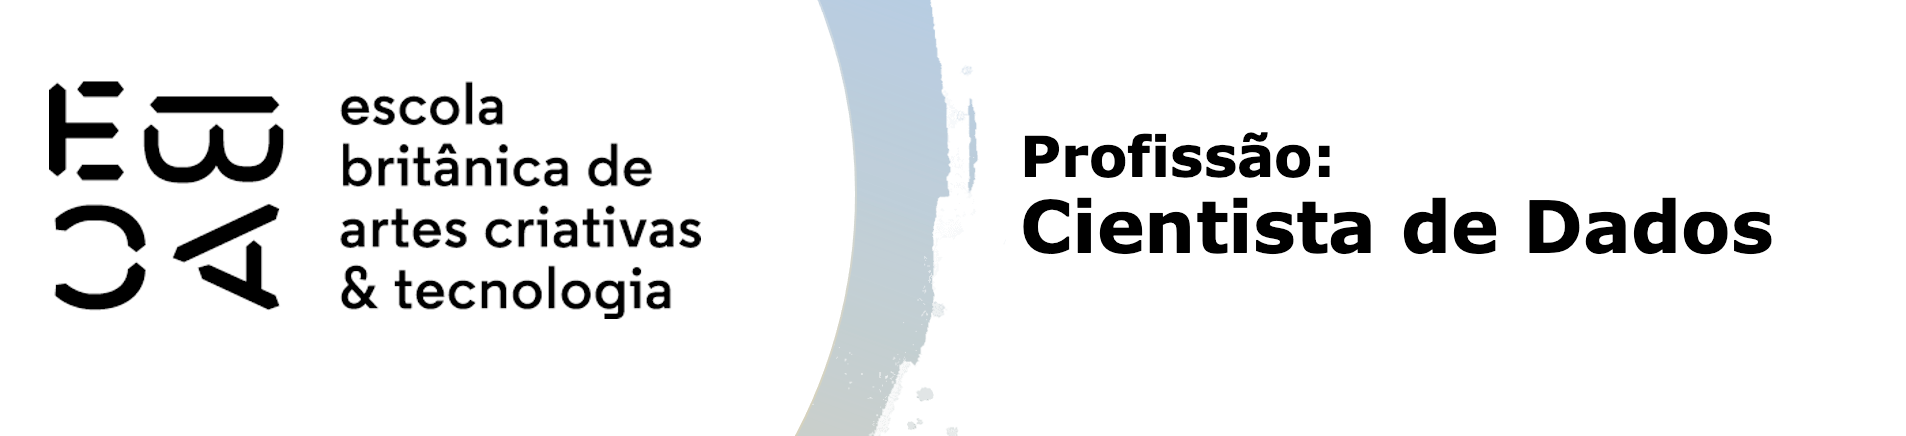

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.cluster.hierarchy as shc

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [6]:
df.isna().sum().sum()

0

In [7]:
df.Weekend.unique()

array([False,  True])

In [8]:
df["Weekend"] = df["Weekend"].astype(int)

In [9]:
df["Revenue"] = df["Revenue"].astype(int)

<Figure size 1200x800 with 0 Axes>

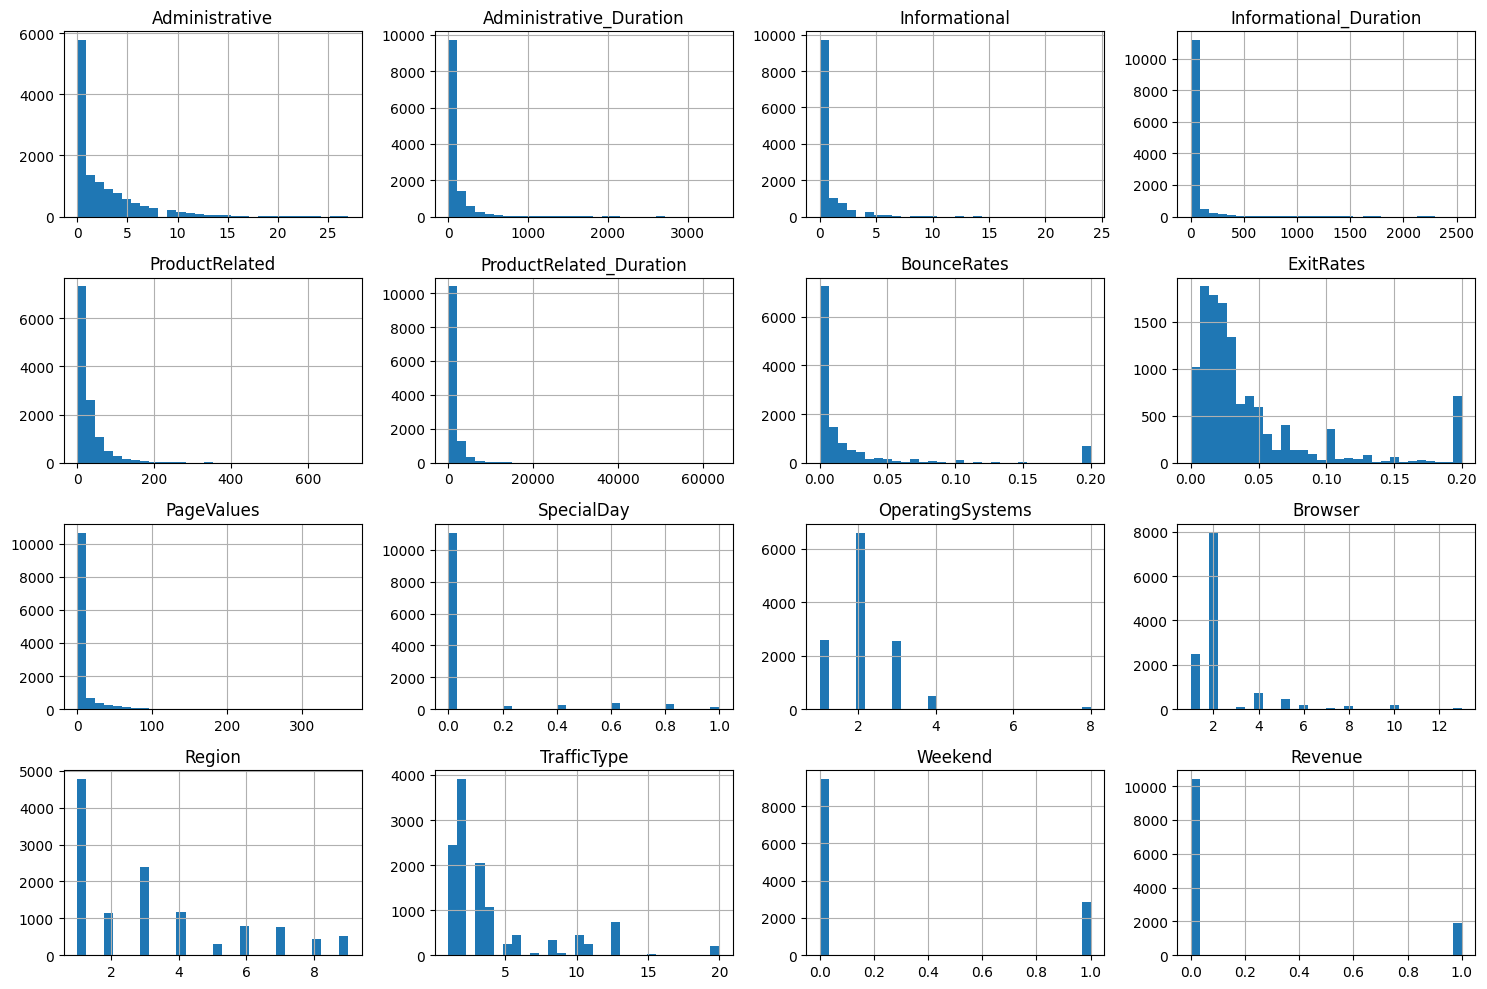

In [10]:
# distribuição das variáveis
plt.figure(figsize=(12, 8))
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [11]:
# Seleção das variáveis

features = [
    "Administrative_Duration", "Informational_Duration",
    "ProductRelated_Duration", "BounceRates", "ExitRates",
    "PageValues", "SpecialDay", "Month", "Weekend", "Revenue"]

df2 = df[features]

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative_Duration  12330 non-null  float64
 1   Informational_Duration   12330 non-null  float64
 2   ProductRelated_Duration  12330 non-null  float64
 3   BounceRates              12330 non-null  float64
 4   ExitRates                12330 non-null  float64
 5   PageValues               12330 non-null  float64
 6   SpecialDay               12330 non-null  float64
 7   Month                    12330 non-null  object 
 8   Weekend                  12330 non-null  int32  
 9   Revenue                  12330 non-null  int32  
dtypes: float64(7), int32(2), object(1)
memory usage: 867.1+ KB


In [13]:
# Variáveis Month
df2 = pd.get_dummies(df2, columns=["Month"], drop_first=True)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative_Duration  12330 non-null  float64
 1   Informational_Duration   12330 non-null  float64
 2   ProductRelated_Duration  12330 non-null  float64
 3   BounceRates              12330 non-null  float64
 4   ExitRates                12330 non-null  float64
 5   PageValues               12330 non-null  float64
 6   SpecialDay               12330 non-null  float64
 7   Weekend                  12330 non-null  int32  
 8   Revenue                  12330 non-null  int32  
 9   Month_Dec                12330 non-null  bool   
 10  Month_Feb                12330 non-null  bool   
 11  Month_Jul                12330 non-null  bool   
 12  Month_June               12330 non-null  bool   
 13  Month_Mar                12330 non-null  bool   
 14  Month_May             

In [14]:
# Selecionando as colunas com Month e convertendo para inteiro
df2[df2.columns[df2.columns.str.contains('Month')]] = df2[df2.columns[df2.columns.str.contains('Month')]].astype(int)

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative_Duration  12330 non-null  float64
 1   Informational_Duration   12330 non-null  float64
 2   ProductRelated_Duration  12330 non-null  float64
 3   BounceRates              12330 non-null  float64
 4   ExitRates                12330 non-null  float64
 5   PageValues               12330 non-null  float64
 6   SpecialDay               12330 non-null  float64
 7   Weekend                  12330 non-null  int32  
 8   Revenue                  12330 non-null  int32  
 9   Month_Dec                12330 non-null  int32  
 10  Month_Feb                12330 non-null  int32  
 11  Month_Jul                12330 non-null  int32  
 12  Month_June               12330 non-null  int32  
 13  Month_Mar                12330 non-null  int32  
 14  Month_May             

In [16]:
df2.isna().sum().sum()

0

## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa. 

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [17]:
# Padronização dos dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df2)

linkage_matrix = linkage(df_scaled, method='complete')

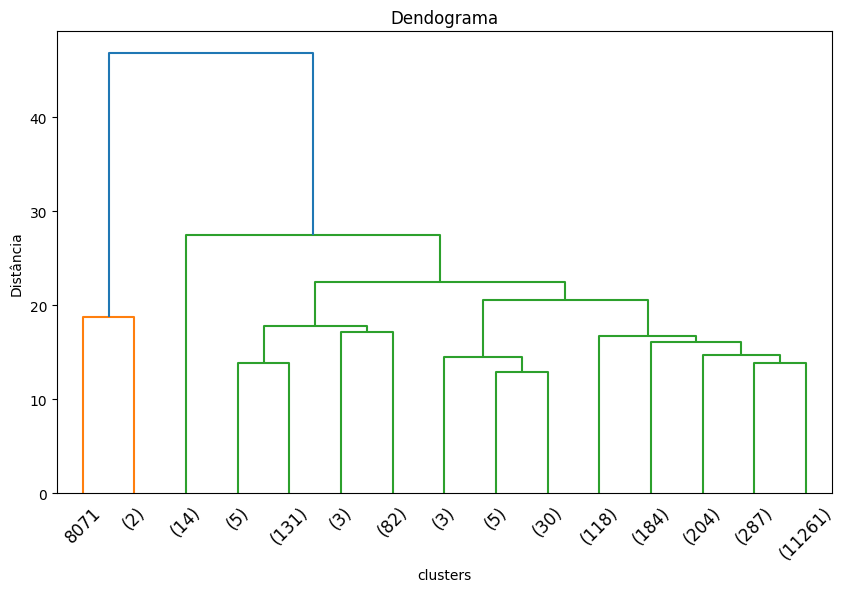

In [54]:
# Dendograma com observações limitadas para não pesar

plt.figure(figsize=(10, 6))

dendrogram(linkage_matrix,
           truncate_mode='lastp', p=15,
           leaf_rotation = 45., leaf_font_size=12.)

plt.title('Dendograma')
plt.xlabel('clusters')
plt.ylabel('Distância')
plt.show()

In [19]:
clusters_3 = fcluster(linkage_matrix, 3, criterion='maxclust')
clusters_4 = fcluster(linkage_matrix, 4, criterion='maxclust')

df2['Cluster_3'] = clusters_3
df2['Cluster_4'] = clusters_4

In [20]:
pd.DataFrame({
    'Cluster_3': df2['Cluster_3'].value_counts(),
    'Cluster_4': df2['Cluster_4'].value_counts()})

,Cluster_3,Cluster_4
1,3.0,3
2,14.0,14
3,12313.0,221
4,NaN,12092


In [52]:
df2.Revenue.unique()

array([0, 1])

In [53]:
df2.BounceRates.unique()

array([0.2       , 0.        , 0.05      , ..., 0.00382775, 0.00086956,
       0.01114899])

In [22]:
# Taxa de conversão por cluster
convercao_3 = df2.groupby('Cluster_3')['Revenue'].mean().reset_index()
convercao_4 = df2.groupby('Cluster_4')['Revenue'].mean().reset_index()

print(f"Taxa de conversão por Cluster 3:\n{convercao_3}\n\n")
print(f"Taxa de conversão por Cluster 4:\n{convercao_4}")

Taxa de conversão por Cluster 3:
   Cluster_3   Revenue
0          1  0.000000
1          2  0.857143
2          3  0.153984


Taxa de conversão por Cluster 4:
   Cluster_4   Revenue
0          1  0.000000
1          2  0.857143
2          3  0.316742
3          4  0.151009


In [23]:
# Proximidade a datas especiais e fim de semana por cluster3

special_day_3 = df2.groupby('Cluster_3')['SpecialDay'].mean().reset_index()
weekend_3 = df2.groupby('Cluster_3')['Weekend'].mean().reset_index()
month_3 = df2.groupby('Cluster_3')[[col for col in df2.columns if col.startswith('Month_')]].sum()


# # Proximidade a datas especiais e fim de semana por cluster4
# special_day_4 = df2.groupby('Cluster_4')['SpecialDay'].mean().reset_index()
# weekend_4 = df2.groupby('Cluster_4')['Weekend'].mean().reset_index()
# month_4 = df2.groupby('Cluster_4')[[col for col in df2.columns if col.startswith('Month_')]].sum()

In [24]:
print(f"Proximidade a datas especiais por Cluster 3:\n\n{special_day_3}")

Proximidade a datas especiais por Cluster 3:

   Cluster_3  SpecialDay
0          1    0.000000
1          2    0.000000
2          3    0.061512


In [25]:
print(f"Distribuição de meses por Cluster 3:\n")
month_3

Distribuição de meses por Cluster 3:



,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
Cluster_3,,,,,,,,,
1,2,0,0,0,0,1,0,0,0
2,5,0,0,0,1,3,3,1,1
3,1720,184,432,288,1906,3360,2995,548,447


*maio e novembro

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [45]:
# Criando uma coluna para identificar os meses
colunas_month = [col for col in df2.columns if col.startswith('Month_')]
df2['Month'] = df2[colunas_month].idxmax(axis = 1).str.replace('Month_', '')

conversao_month_3 = (
    df2.groupby(['Cluster_3', 'Month'])[['Revenue','BounceRates']]
    .mean()
    .reset_index())

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [50]:
# pivoteamento
pivot_data = conversao_month_3.pivot(index='Month', columns='Cluster_3', values='Revenue')
pivot_data = pivot_data.reindex(month_order)

pivot_data_bounce = conversao_month_3.pivot(index='Month', columns='Cluster_3', values='BounceRates')
pivot_data_bounce = pivot_data_bounce.reindex(month_order)

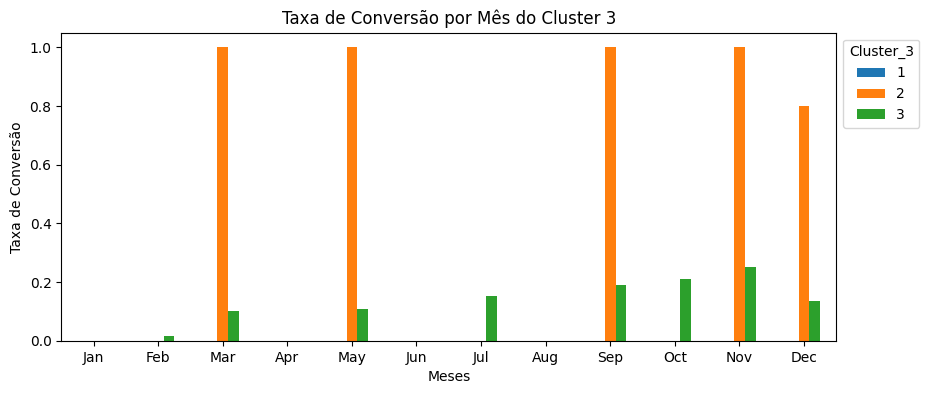

In [47]:
pivot_data.plot(kind = 'bar', figsize = (10, 4))

plt.title('Taxa de Conversão por Mês do Cluster 3')
plt.xlabel('Meses')
plt.ylabel('Taxa de Conversão')
plt.legend(title = 'Cluster_3', loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=0)
plt.show()

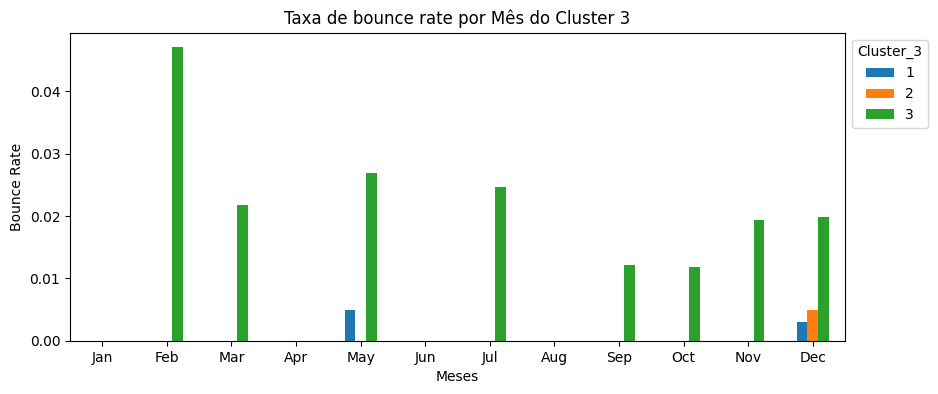

In [51]:
pivot_data_bounce.plot(kind = 'bar', figsize = (10, 4))

plt.title('Taxa de bounce rate por Mês do Cluster 3')
plt.xlabel('Meses')
plt.ylabel('Bounce Rate')
plt.legend(title = 'Cluster_3', loc='upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=0)
plt.show()